In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder
FOLDERNAME = 'Stanford/final_project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
# Tutorial followed: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler, Subset
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import os
import time

import pandas as pd
import numpy as np

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# print_every = 300
batch_size = 64
len_data = 12800
input_size = 224
data_dir = '/content/drive/My Drive/Stanford/final_project/top_20/'
print('using device:', device)

using device: cuda


In [3]:
classes = os.listdir(data_dir)
print(len(classes))

17


In [4]:
train_tfms = T.Compose([
    T.Resize(input_size), 
    T.ToTensor()
])

all_data = ImageFolder(data_dir, transform=train_tfms)
num_classes = len(all_data.class_to_idx)
all_data = Subset(all_data, np.random.choice(len(all_data), len_data, replace=False))
print(all_data[0][0].shape)
print(len(all_data))

train_len = int(len_data*0.7)
val_len = int(len_data*0.2)
test_len = len_data - (train_len + val_len)
train, val, test = torch.utils.data.random_split(all_data, [train_len, val_len, test_len])
train_dl = DataLoader(train, batch_size, num_workers=2, shuffle=True, pin_memory=True)
val_dl = DataLoader(val, batch_size, num_workers=2, shuffle=True, pin_memory=True)
test_dl = DataLoader(test, batch_size, shuffle=True, pin_memory=True)

dataloaders = {'train': train_dl, 'val': val_dl}

torch.Size([3, 224, 224])
12800


In [5]:
def train_model(model, dataloaders, criterion, optimizer, name='inception_v3_generic', num_epochs=25, is_inception=True):
    since = time.time()

    val_acc_history = []
    val_acc3_history = []
    train_acc_history = []
    train_acc3_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_corrects3 = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        # print(len(model(inputs)))
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # acc@3
                _, pred = outputs.topk(3, 1, True, True)
                pred = pred.t()
                correct = pred.eq(labels.view(1, -1).expand_as(pred))
                correct_k = correct[:3].reshape(-1).float().sum(0)
                running_corrects3 += correct_k

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_acc3 = running_corrects3.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f} Acc@3: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_acc3))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Saving model...')
                torch.save(model.state_dict(), f'/content/drive/My Drive/{FOLDERNAME}results/{name}.pth')
            if phase == 'val':
                val_acc_history.append(epoch_acc.item())
                val_acc3_history.append(epoch_acc3.item())
            else: 
                train_acc_history.append(epoch_acc.item())
                train_acc3_history.append(epoch_acc3.item())

        print("Saving training history...")
        data = pd.DataFrame(
            {'epoch': list(range(epoch + 1)), 
             'train_acc': train_acc_history, 
             'val_acc': val_acc_history, 
             'train_acc3': train_acc3_history, 
             'val_acc3': val_acc3_history})
        data.to_csv(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.csv')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [6]:
def set_parameter_requires_grad(model, feature_extracting=True): 
  if feature_extracting: 
    for param in model.parameters(): 
      param.requires_grad = False

In [7]:
def initialize_model(num_classes, feature_extract=True, use_pretrained=True): 
  model_ft = models.vgg19_bn(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.classifier[6].in_features
  model_ft.classifier[6] = nn.Sequential(
      nn.Linear(num_ftrs, num_classes), 
  )
  # model_ft.fc = nn.Sequential(nn.Dropout(drop_prob), nn.Linear(num_ftrs, num_classes))
  return model_ft, input_size

model_ft, input_size = initialize_model(num_classes, True, True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 25

In [8]:
# Send model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized / updated in this run. If we are
# finetuning we will be updating all parameters. However, if we are doing
# feature extract method, we will only update the parameters that we have 
# just initialized, i.e. the parameters with requires_grad = True
params_to_update = model_ft.parameters()
print("Params to learn:")
params_to_update = []
for name, param in model_ft.named_parameters():
  if param.requires_grad == True: 
    params_to_update.append(param)
    print('\t', name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001)

Params to learn:
	 classifier.6.0.weight
	 classifier.6.0.bias


In [9]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, name='vgg19_bn_30_epochs_top_20_128dpts_adam_twofc', num_epochs=30, is_inception=False)

Epoch 0/29
----------
train Loss: 2.5569 Acc: 0.2102 Acc@3: 0.4395
val Loss: 2.3384 Acc: 0.3266 Acc@3: 0.5398
Saving model...
Saving training history...

Epoch 1/29
----------
train Loss: 2.2838 Acc: 0.3187 Acc@3: 0.5535
val Loss: 2.1494 Acc: 0.3883 Acc@3: 0.6191
Saving model...
Saving training history...

Epoch 2/29
----------
train Loss: 2.1169 Acc: 0.3677 Acc@3: 0.6230
val Loss: 2.0109 Acc: 0.4238 Acc@3: 0.6836
Saving model...
Saving training history...

Epoch 3/29
----------
train Loss: 2.0002 Acc: 0.4070 Acc@3: 0.6765
val Loss: 1.9061 Acc: 0.4559 Acc@3: 0.7262
Saving model...
Saving training history...

Epoch 4/29
----------
train Loss: 1.9003 Acc: 0.4304 Acc@3: 0.7071
val Loss: 1.8220 Acc: 0.4738 Acc@3: 0.7559
Saving model...
Saving training history...

Epoch 5/29
----------
train Loss: 1.8256 Acc: 0.4538 Acc@3: 0.7391
val Loss: 1.7545 Acc: 0.5027 Acc@3: 0.7793
Saving model...
Saving training history...

Epoch 6/29
----------
train Loss: 1.7611 Acc: 0.4767 Acc@3: 0.7588
val Loss:

In [49]:
def load_model(model, path): 
  '''
  Load model from saved parameters.
  '''
  model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))
  model.to(device)
  model.eval()
  return model

model = load_model(model_ft, f'/content/drive/My Drive/{FOLDERNAME}results/resnet50_pretrained_30_epochs_all_adam_threelayer_dropout03.pth')

RuntimeError: ignored

In [37]:
val = dataloaders['val']

@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    for batch in loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds)
            ,dim=0
        )

        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_preds, all_labels

preds, targets = get_all_preds(model_ft, val)

print(preds)

tensor([[-1.1340,  0.7589,  2.9390,  ..., -0.1207, -0.2253,  0.5430],
        [ 0.8920, -1.7828,  0.9704,  ..., -0.4023, -1.2933,  0.1472],
        [-0.1084, -0.1995, -0.0731,  ...,  1.2621, -0.2728, -0.3195],
        ...,
        [-3.4449,  1.4176, -0.1436,  ...,  1.3547,  1.7209,  0.6509],
        [-0.7640,  3.4284,  2.8180,  ...,  0.2229, -1.5841,  0.9956],
        [-4.1307,  0.9387,  2.5590,  ...,  0.0122, -2.5186,  1.5719]],
       device='cuda:0')


In [38]:
print((targets == preds.argmax(dim=1)).float().mean())

tensor(0.6043, device='cuda:0')


In [39]:
stacked = torch.stack(
    (
        targets, preds.argmax(dim=1)
    ), 
    dim=1
)
print(stacked.shape)
cmt = torch.zeros(num_classes, num_classes, dtype=torch.int64)
for p in stacked: 
  t1, p1 = p.tolist()
  t1 = int(t1)
  p1 = int(p1)
  cmt[t1, p1] = cmt[t1, p1] + 1
print(cmt)

torch.Size([2560, 2])
tensor([[ 48,   0,   0,   1,   2,   1,   2,   0,   0,   0,   0,   0,   8,   3,
           4,   1,   3],
        [  0,  27,  46,   0,   0,   0,   0,   1,   2,   0,   0,   0,  18,   0,
           5,   0,   0],
        [  1,  16, 331,   3,   2,   0,   6,   2,   2,   0,   2,   0,  42,   4,
          11,   0,   4],
        [  0,   1,  17,  37,   2,   1,   3,   1,   0,   0,   0,   0,   9,   2,
           5,   1,   5],
        [  1,   0,   5,   4,  36,   7,   0,   0,   0,   0,   0,   0,   2,   0,
           1,   0,   2],
        [  0,   0,   1,   0,   1,  60,   9,   0,   0,   0,   0,   0,   1,   3,
           0,   0,   5],
        [  0,   0,  17,   2,   2,   8, 122,   8,   2,   1,   7,   0,  20,  13,
          34,   4,   6],
        [  0,   6,   7,   1,   0,   3,   8,  55,   1,   0,   0,   0,  11,   4,
           9,   0,   6],
        [  0,   1,  11,   0,   0,   0,   0,   0,  50,   0,   0,   0,   7,   2,
           6,   1,   0],
        [  0,   0,  17,   0,   0,   0,  12

Normalized confusion matrix
[[0.65753425 0.         0.         0.01369863 0.02739726 0.01369863
  0.02739726 0.         0.         0.         0.         0.
  0.10958904 0.04109589 0.05479452 0.01369863 0.04109589]
 [0.         0.27272727 0.46464646 0.         0.         0.
  0.         0.01010101 0.02020202 0.         0.         0.
  0.18181818 0.         0.05050505 0.         0.        ]
 [0.00234742 0.03755869 0.77699531 0.00704225 0.00469484 0.
  0.01408451 0.00469484 0.00469484 0.         0.00469484 0.
  0.09859155 0.00938967 0.0258216  0.         0.00938967]
 [0.         0.01190476 0.20238095 0.44047619 0.02380952 0.01190476
  0.03571429 0.01190476 0.         0.         0.         0.
  0.10714286 0.02380952 0.05952381 0.01190476 0.05952381]
 [0.01724138 0.         0.0862069  0.06896552 0.62068966 0.12068966
  0.         0.         0.         0.         0.         0.
  0.03448276 0.         0.01724138 0.         0.03448276]
 [0.         0.         0.0125     0.         0.0125     0

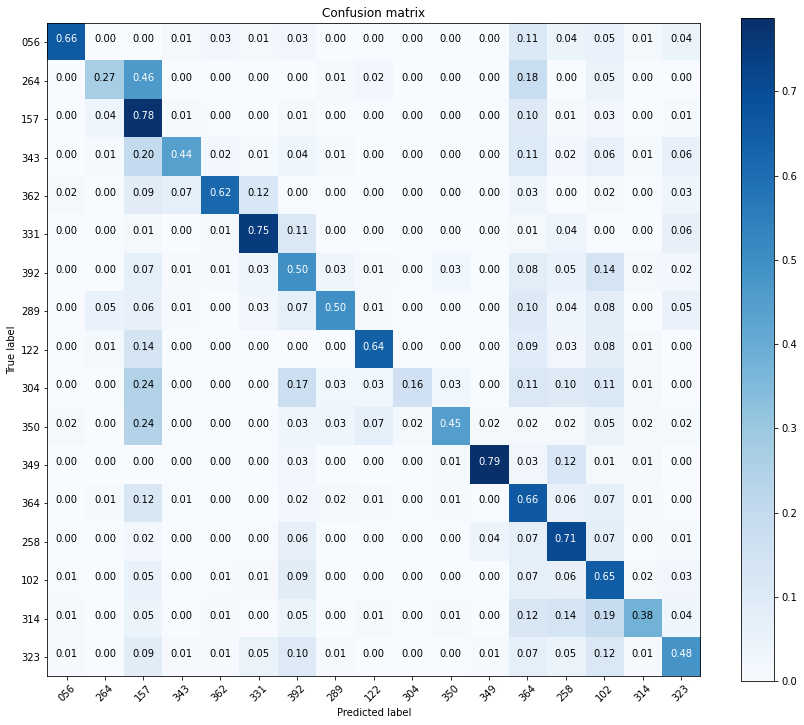

In [48]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets.cpu(), preds.cpu().argmax(dim=1))

import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, name='plot'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix, ResNet")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig(f'/content/drive/My Drive/{FOLDERNAME}results/{name}.png')

plt.figure(figsize=(12, 10))
plot_confusion_matrix(cm, classes, normalize=True,name='confusion_matrix_vgg_normalized')

In [ ]:
def get_all_labels(loader):
    all_labels = torch.tensor([])
    for batch in loader:
        images, labels = batch
        all_labels = torch.cat((all_labels, labels), dim=0)
    return all_labels
targets = get_all_labels(val)

In [ ]:
print((targets == preds.argmax(dim=1)).float().mean())

tensor(0.0945)


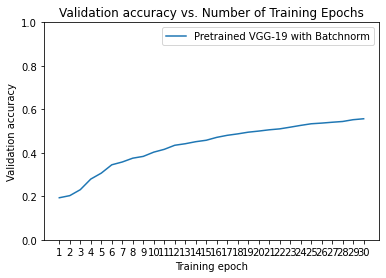

In [ ]:
# Plot the training curve of validation accuracy vs. number of epochs
ohist = hist

plt.title("Validation accuracy vs. Number of Training Epochs")
plt.xlabel("Training epoch")
plt.ylabel("Validation accuracy")
plt.plot(range(1, 31), ohist, label="Pretrained VGG-19 with Batchnorm")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, 31, 1.0))
plt.legend()
plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, name='vgg19_bn_30_epochs_top_20_128dpts_adam_twofc_v2', num_epochs=30, is_inception=False)

Epoch 0/29
----------
train Loss: 2.5570 Acc: 0.2083 Acc@3: 0.4278
val Loss: 2.3632 Acc: 0.2988 Acc@3: 0.5039
Saving model...
Saving training history...

Epoch 1/29
----------
train Loss: 2.2681 Acc: 0.3196 Acc@3: 0.5559
val Loss: 2.1723 Acc: 0.3664 Acc@3: 0.6027
Saving model...
Saving training history...

Epoch 2/29
----------
train Loss: 2.1091 Acc: 0.3683 Acc@3: 0.6292
val Loss: 2.0306 Acc: 0.4105 Acc@3: 0.6719
Saving model...
Saving training history...

Epoch 3/29
----------
train Loss: 1.9774 Acc: 0.4095 Acc@3: 0.6829
val Loss: 1.9263 Acc: 0.4441 Acc@3: 0.7191
Saving model...
Saving training history...

Epoch 4/29
----------
train Loss: 1.8857 Acc: 0.4393 Acc@3: 0.7224
val Loss: 1.8425 Acc: 0.4641 Acc@3: 0.7410
Saving model...
Saving training history...

Epoch 5/29
----------
train Loss: 1.8048 Acc: 0.4600 Acc@3: 0.7475
val Loss: 1.7787 Acc: 0.4824 Acc@3: 0.7629
Saving model...
Saving training history...

Epoch 6/29
----------
train Loss: 1.7406 Acc: 0.4834 Acc@3: 0.7715
val Loss:

In [ ]:
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, name='vgg19_bn_30_epochs_all_pics_128dpts_adam_twofc', num_epochs=30, is_inception=False)

Epoch 0/29
----------
train Loss: 5.3634 Acc: 0.0796 Acc@3: 0.1702
val Loss: 4.9732 Acc: 0.1207 Acc@3: 0.2430
Saving model...
Saving training history...

Epoch 1/29
----------
train Loss: 4.7706 Acc: 0.1330 Acc@3: 0.2537
val Loss: 4.6204 Acc: 0.1668 Acc@3: 0.2687
Saving model...
Saving training history...

Epoch 2/29
----------
train Loss: 4.5157 Acc: 0.1623 Acc@3: 0.2775
val Loss: 4.4270 Acc: 0.1813 Acc@3: 0.2867
Saving model...
Saving training history...

Epoch 3/29
----------
train Loss: 4.3646 Acc: 0.1790 Acc@3: 0.2949
val Loss: 4.2931 Acc: 0.1941 Acc@3: 0.3090
Saving model...
Saving training history...

Epoch 4/29
----------
train Loss: 4.2436 Acc: 0.1916 Acc@3: 0.3151
val Loss: 4.1852 Acc: 0.2090 Acc@3: 0.3273
Saving model...
Saving training history...

Epoch 5/29
----------
train Loss: 4.1359 Acc: 0.2006 Acc@3: 0.3384
val Loss: 4.0914 Acc: 0.2164 Acc@3: 0.3484
Saving model...
Saving training history...

Epoch 6/29
----------
train Loss: 4.0544 Acc: 0.2173 Acc@3: 0.3536
val Loss:

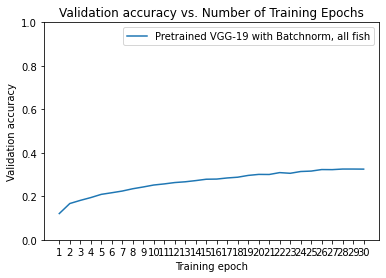

In [ ]:
# Plot the training curve of validation accuracy vs. number of epochs
ohist = hist

plt.title("Validation accuracy vs. Number of Training Epochs")
plt.xlabel("Training epoch")
plt.ylabel("Validation accuracy")
plt.plot(range(1, 31), ohist, label="Pretrained VGG-19 with Batchnorm, all fish")
plt.ylim((0, 1.))
plt.xticks(np.arange(1, 31, 1.0))
plt.legend()
plt.show()